# Compressing the System

## Overview

### Questions

* How do I compress the system to a target density? 
* What is a packing fraction?

### Objectives

* Show how to compute the **packing fraction** of a system.
* Explain how how an **Updater** is an **operation** that modifies the system when its **Trigger** returns `True`.
* Demonstrate using the **QuickCompress** updater to achieve a target packing fraction.
* Demonstrate using the **TrialMoveSize** tuner to adjust the trial move size.
* Show how operations can **complete** the simulation run.

## Boilerplate code

In [1]:
import hoomd
import math
import copy

The `render` function in the next cell will render a snapshot using **fresnel**.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [2]:
import fresnel

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=370, h=370)

def render(snapshot):
    L = snapshot.configuration.box[0]
    vertices=[(-0.5, 0, 0),
               (0.5, 0, 0),
               (0, -0.5, 0),
               (0, 0.5, 0),
               (0, 0, -0.5),
               (0, 0, 0.5)]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(scene,
                                                 poly_info,
                                                 N=snapshot.particles.N)
    geometry.material = fresnel.material.Material(color=(0.1, 0.7, 0.25),
                                                  roughness=0.8)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.orientation[:] = snapshot.particles.orientation[:]
    geometry.outline_width = 0.01
    box = fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=.02)
    

    scene.lights = fresnel.light.lightbox()
    scene.camera = fresnel.camera.orthographic(position=(0, 0, L+1),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L+1)
    return tracer.sample(scene, samples=500)

## Packing fraction

Self-assembly in hard particle systems typically occurs at a **packing fraction** above 0.5.
The **packing fraction** is the ratio of the volume occupied by the particles to the volume of the **periodic box**.
So far in this tutorial, we have **randomized** a system of *N* octahedra in a box with a very low packing fraction and stored that in `random.gsd`.
Let's initialize a **Simulation** with this configuration and see what packing fraction it is at.

In [3]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu)
sim.create_state_from_gsd(filename='random.gsd')

HOOMD-blue v2.9.2-2080-g74f84bf9e GPU [CUDA] (10.2) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX AVX2 
Compiled: 08/03/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
HOOMD-blue is running on the CPU


Compute the [volume of our octahedron](https://en.wikipedia.org/wiki/Octahedron):

In [4]:
a = math.sqrt(2)/2
V_particle = 1/3 * math.sqrt(2) * a**3

Compute the **packing fraction** (TODO: Add number of particles to state?)

In [5]:
initial_packing_fraction = sim.state.snapshot.particles.N * V_particle / sim.state.box.volume
print(initial_packing_fraction)

0.09126759678492466


As you can see, this **packing fraction** is very low and the box volume needs to be significantly reduced to achieve a **packing fraction** above 0.5.

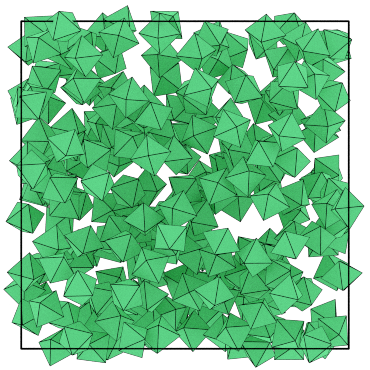

In [6]:
render(sim.state.snapshot)

We will use HPMC to move particles into non-overlapping configurations while we compress the system.
Set up the HPMC integrator for the octahedron simulations:

In [7]:
mc = hoomd.hpmc.integrate.ConvexPolyhedron(seed=42)
mc.shape['octahedron'] = dict(vertices=[(-0.5, 0, 0),
                                         (0.5, 0, 0),
                                         (0, -0.5, 0),
                                         (0, 0.5, 0),
                                         (0, 0, -0.5),
                                         (0, 0, 0.5)])
sim.operations.integrator = mc

## The QuickCompress updater

An **Updater** is a type of **operation** in HOOMD-blue that makes changes to the **state**.
To use an **Updater**, we need to instantiate the object, assign a **Trigger**, and add it to the **Simulation**.
**Simulation** will apply the **Updater** on **time steps** where the **Trigger** is `True`.
The most commonly used **Trigger** is **PeriodicTrigger** which executes the **Updater** every `period` steps.

**QuickCompress** is an **Updater** that works with HPMC to quickly compress the box to a target volume.
When triggered, **QuickCompress** reduces the box volume by a scale factor, while *allowing slight overlaps between the particles*.
It then waits for the translation and rotation **trial moves** to remove these overlaps before it reduces the volume again.
This process temporarily produces invalid system configurations, but is much quicker than a process that does not allow temporary overlaps.

Compute the final box size with a **packing fraction** above 0.5 and configure a **QuickCompress** to **trigger** every 10 **time steps**.

In [8]:
initial_box = sim.state.box
final_box = hoomd.Box.from_box(initial_box)
final_packing_fraction = 0.57
final_box.volume = sim.state.snapshot.particles.N * V_particle / final_packing_fraction
compress = hoomd.hpmc.update.QuickCompress(trigger=hoomd.trigger.Periodic(10), seed=10, target_box = final_box)

Add the **Updater** to the **Simulation**:

In [9]:
sim.operations.updaters.append(compress)

## The TrialMoveSize tuner

A **Tuner** is another type of **operation**.
**Tuners** make changes to other **operations** or the system **state** to improve performance.
In HPMC, the translation and rotation trial move sizes have a *huge* performance impact.
When the move size is too small it takes many time steps to make appreciable changes to the system.
When the move size is too large very few moves are accepted and it again takes many time steps to make appreciable changes.
The system makes the most progress at moderate move sizes and, in most cases, the optimal **acceptance ratio** is 20%.
The **TrialMoveSize** tuner monitors the **acceptance ratio** and adjusts `d` and `a` to achieve this target.

The optimal move size depends on the density of the system.
We are changing the density rapidly during compression, so we use the **TrialMoveSize** tuner to adjust the move sizes regularly:

In [10]:
# TODO: Implement the tuner in the v3 API
# tune = hoomd.hpmc.tune.TrialMoveSize(integrator=mc, tune=['a', 'd'], trigger=hoomd.trigger.Periodic(10))
# sim.operations.tuners.append(tune)

# temporary move sizes
mc.d['octahedron'] = 0.02
mc.a['octahedron'] = 0.019871213815167245

## Run until complete

The **QuickCompress** updater will **complete** the simulation run when it reaches the target box size.
This will stop the run before the requested number of **time steps** is executed.
Run for enough steps to complete the compression:

In [11]:
sim.run(1e6)

Notice that the simulation stopped early when the **QuickCompress** operation reached the target box.

In [12]:
sim.timestep

12321

Check to see if the compression completed successfully:

In [13]:
if not compress.complete:
    raise RuntimeError("Compression failed to complete")

Now that the compression is complete, the particles are much closer together and not overlapping, but still arranged randomly.

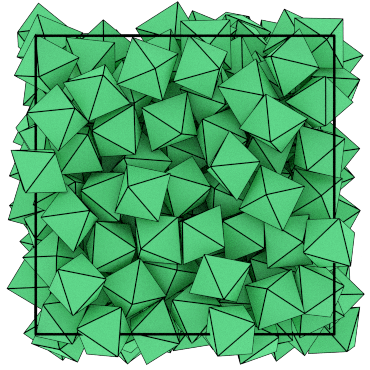

In [14]:
render(sim.state.snapshot)

Let's save the final configuration to a GSD file for use in the next stage of the simulation.

In [15]:
hoomd.dump.GSD.write(state=sim.state, filename='compressed.gsd')

[Previous section](04-Randomizing-the-System.ipynb). [Next section](06-Equilibrating-the-System.ipynb).